# Обучение модели детекции PiP (picture in picture)
1. Генерация данных для обучения
2. Обучение YoloV8
3. Валидация на реальных данных

## Подготовка датасета для генерации
Для генерации PiP будет использоваться открытый датасет COCO 2017 (train, val, test).

Из всех изображений будут выбраны горизонтальные с соотношением сторон близким к 16:9.

Полученные изображения будут поделены на 2 группы: 1) изображение, в которое будет вставляться PiP, 2) изображение для вставки PiP.

После генерации изображений будут сделаны 3 группы: train, val, test (80, 10, 10). Финальное тестирование будет на изображениях с PiP в Rutube.

In [ ]:
# pip install pandas tqdm matplotlib imagesize ultralytics albumentations

In [1]:
import glob
import os

import cv2
import imagesize
import pandas as pd
from tqdm import tqdm

In [2]:
# переходим в предыдущую директори
os.chdir('../')

In [3]:
images = glob.glob('data/pip/train2017/**') + glob.glob('data/pip/test2017/**') + glob.glob('data/pip/val2017/**')

In [4]:
len(images)

163957

In [5]:
data = []
for filename in tqdm(images):
    width, height = imagesize.get(filename)
    data.append({
        'image': filename,
        'height': height,
        'width': width
    })

100%|██████████| 163957/163957 [00:04<00:00, 37170.30it/s]


In [6]:
df_images = pd.DataFrame(data)

In [7]:
df_images['ratio'] = df_images['width'] / df_images['height']
df_filtered = df_images[(df_images['ratio'] > 1.3) & (df_images['ratio'] < 2)]
df_filtered = df_filtered[df_filtered['width'] > 600]

In [8]:
len(df_filtered)

96052

In [9]:
# делим на 2 группы: оригинальное изображение и изображение для PiP
df_orig = df_filtered[:(len(df_filtered) // 2)]
df_insert = df_filtered[(len(df_filtered) // 2):]

In [10]:
len(df_orig), len(df_insert)

(48026, 48026)

In [11]:
# перемешиваем
df_orig = df_orig.sample(frac=1).reset_index(drop=True)
df_insert = df_insert.sample(frac=1).reset_index(drop=True)

## Алгоритм для генерации
Для генерации будут использоваться библиотеки Albumentations (аугментирование изображений) и cv2 для работы с изображениями вставки PiP.

Перед вставкой видео будет преобразовываться (аугментироваться). Будут использоваться следующие преобразования (все аугментации будут применяться по порядку с указанной вероятностью):
1. Добавление небольшого размытия (p=0.5)
2. Небольшой поворот изображения без интерполяции (p=0.5)
3. Цветовое преобразование: изменение цвета (p=0.35) или преобразование в чёрно-белое изображение (p=0.65) с вероятностью p=0.2
4. Добавление чёрного отступа от краёв изображения (p=0.5)

Изображение будет вставляться в случайное место, с размером от 0.3 до 0.75 от оригинального изображения, при этом оно будет вставляться с небольшой прозрачностью.

In [12]:
import random
import json

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from albumentations.pytorch import ToTensorV2

In [13]:
def augment_image(image: np.ndarray) -> np.ndarray:
    """Применение аугментаций к изображению.

    :param image: изображение для аугментирования
    :return: преобразованное изображение
    """
    transform = A.Compose([
        A.PadIfNeeded(min_height=image.shape[0]+40, min_width=image.shape[1]+40, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5),
        A.Rotate(limit=(-20,20), border_mode=cv2.BORDER_CONSTANT, value=0, interpolation=0, p=0.5),
        A.OneOf([
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.35),
            A.ToGray(p=0.65)
        ], p=0.2),
        A.GaussianBlur(blur_limit=(3, 9), p=0.5),
    ])
    augmented = transform(image=image)
    return augmented['image']

def create_pip_image(
    base_image: np.ndarray,
    inserted_image: np.ndarray,
) -> tuple[np.ndarray, list[float]]:
    """Вставка изображения PiP.

    :param base_image: изображение куда будет вставляться PiP
    :param inserted_image: изображение для вставки PiP
    :return: изображение с PiP и бокс PiP в формате COCO
    """
    h, w, _ = base_image.shape
    ih, iw, _ = inserted_image.shape

    # подсчёт размеров для вставки
    max_scale = min(w / iw, h / ih) * 1.0
    scale = random.uniform(0.25, 0.8)
    resized_inserted_image = cv2.resize(inserted_image, (int(iw * scale), int(ih * scale)))

    # применение аугментации
    resized_inserted_image = augment_image(resized_inserted_image)

    ih, iw, _ = resized_inserted_image.shape

    # позиция для вставки
    x_min = random.randint(0, w - iw)
    y_min = random.randint(0, h - ih)

    # вставка изображения с прозрачностью с вероятностью 0.5
    if random.randint(0, 1):
        alpha = random.uniform(0.7, 0.9)
    else:
        alpha = 1.0
    overlay = base_image.copy()
    overlay[y_min:y_min+ih, x_min:x_min+iw] = resized_inserted_image

    cv2.addWeighted(overlay, alpha, base_image, 1 - alpha, 0, base_image)
   
    # подсчёт центров точек боксов
    x_center = x_min + iw / 2
    y_center = y_min + ih / 2

    # бокс изображения PiP в COCO формате
    bbox = [
        x_center / w,
        y_center / h,
        iw / w,
        ih / h,
    ]

    return base_image, bbox

def display_pip_with_box(
    image: np.ndarray,
    coco_box: list[float],
) -> None:
    """Отображение изображения с PiP с выделением бокса по аннотации
    
    :param image: изображение с PiP
    :param icoco_box: бокс PiP в формате COCO
    """
    image_with_bbox = image.copy()

    h, w, _ = image.shape
    
    x_center = coco_box[0] * w
    y_center = coco_box[1] * h
    box_width = coco_box[2] * w
    box_height = coco_box[3] * h
    
    x_min = int(x_center - box_width / 2)
    y_min = int(y_center - box_height / 2)
    x_max = int(x_center + box_width / 2)
    y_max = int(y_center + box_height / 2)
    
    # Draw rectangle
    cv2.rectangle(
        image_with_bbox, 
        (x_min, y_min), 
        (x_max, y_max), 
        (255, 0, 0), 2,
     )
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## Примеры генерации

/home/vladislav/anaconda3/envs/copyright/lib/python3.10/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


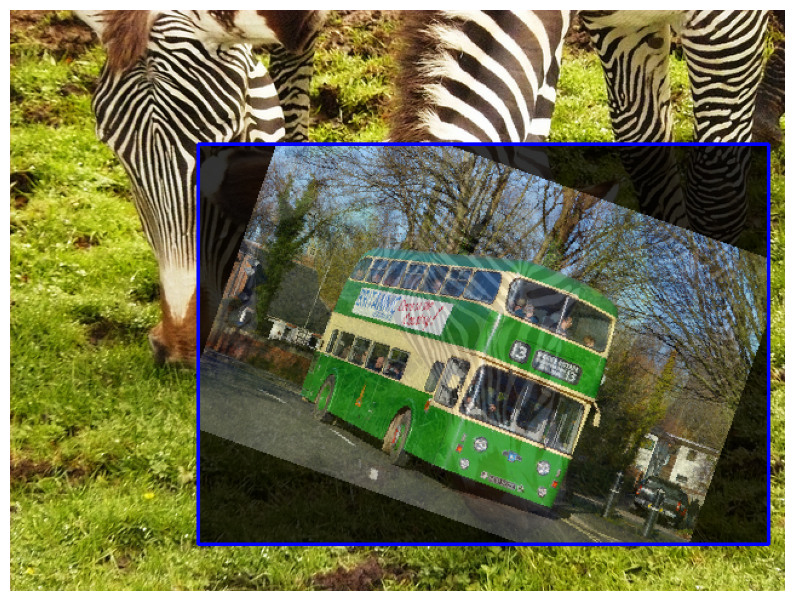

In [14]:
orig_image = cv2.imread(df_orig.iloc[0].image)
insert_image = cv2.imread(df_insert.iloc[0].image)

pip_image, pip_box = create_pip_image(orig_image, insert_image)
display_pip_with_box(pip_image, pip_box)

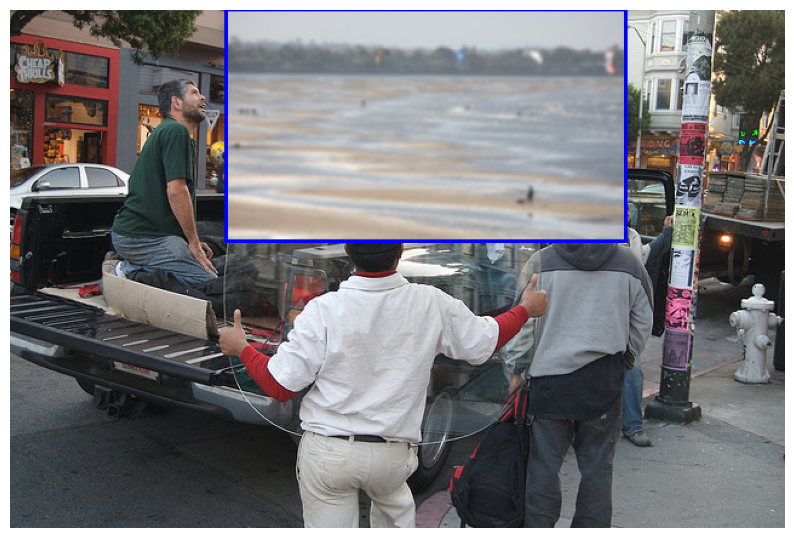

In [15]:
orig_image = cv2.imread(df_orig.iloc[1].image)
insert_image = cv2.imread(df_insert.iloc[1].image)

pip_image, pip_box = create_pip_image(orig_image, insert_image)
display_pip_with_box(pip_image, pip_box)

## Генерация изображений
1. Делим датасет на 3 группы (train, val, test)
2. Создаём директории в COCO формате (images/{train, val, test}), labels/{train, val, test}
3. Генерируем изображения для каждого датасета, сохраняем метаданные
4. Валидируем сгенерированные изображения

In [16]:
import os
import uuid

### Подготовка датасетов

In [17]:
# датасет с полями orig_image, insert_image 
df_orig_craft = df_orig.rename(columns={'image': 'orig_image'})[['orig_image']].reset_index(drop=True)
df_insert_craft = df_insert.rename(columns={'image': 'insert_image'})[['insert_image']].reset_index(drop=True)
df_craft = df_orig_craft.join(df_insert_craft).sample(frac=1).reset_index(drop=True)

In [18]:
len(df_craft)

48026

In [19]:
train_size = int(len(df_craft) * 0.8)
df_craft_train = df_craft[:train_size]

df_craft_val_test = df_craft[train_size:]
val_size = len(df_craft_val_test) // 2

df_craft_val = df_craft_val_test[:val_size]
df_craft_test = df_craft_val_test[val_size:]

In [20]:
len(df_craft_train), len(df_craft_val), len(df_craft_test)

(38420, 4803, 4803)

In [21]:
DATA_DIR = 'data/pip/crafted'
os.makedirs(DATA_DIR)

df_craft_train.to_csv(f'{DATA_DIR}/raw_train.csv', index=False)
df_craft_val.to_csv(f'{DATA_DIR}/raw_val.csv', index=False)
df_craft_test.to_csv(f'{DATA_DIR}/raw_test.csv', index=False)

### Пайплайн генерации

In [22]:
def craft_dataset(
    df_craft: pd.DataFrame,
    data_path: str,
    dataset_type: str,
) -> None:
    """Генерация датасета для детекции PiP.

    создаёт директории в формате PiP и сохраняет датафрейм с мета-информацией.
    с вероятностью 0.5 вставялет изоюражение PiP
    
    :param df_craft: датафрейм с полями 'orig_image' 'insert_image'
    :param data_path: путь для создания датасета 'path/to/dataset'
    :param dataset_type: train, test, val
    """
    dataset = []
    bad_images = 0
    images_dir = f'{data_path}/images/{dataset_type}'
    labels_dir = f'{data_path}/labels/{dataset_type}'

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for _, row in tqdm(df_craft.iterrows(), total=len(df_craft)):
        # уникальный ID для изображения и аннотации
        file_uuid = str(uuid.uuid4())
        img_path = f'{images_dir}/{file_uuid}.png'
        label_path = f'{labels_dir}/{file_uuid}.txt'
        
        # метка наличия PiP, если True, то вставлятся изображение и пишется бокс в аннотацию 
        make_pip = bool(random.randint(0, 1))

        orig_image = cv2.imread(row.orig_image)

        # изображение без PiP
        if not make_pip:
            img_class = 'orig' 
            # аугментирование изображения
            aug_image = augment_image(orig_image)
            cv2.imwrite(img_path, aug_image)

            # сохранение пустой аннотации
            with open(label_path, 'w') as fout:
                print('', file=fout)
        # изображение с PiP
        else:
            img_class = 'pip' 
            insert_image = cv2.imread(row.insert_image)

            # в случае если не получилось вставить изображение -- пропускаем пару
            try:
                pip_image, pip_box = create_pip_image(orig_image, insert_image)

                # изображение вставилось без ошибок
                cv2.imwrite(img_path, pip_image)
                # сохранение аннотации в формате COCO: class box
                with open(label_path, 'w') as fout:
                    print('0 ' + str(pip_box).replace(',', '')[1:-1], file=fout)
            except:
                bad_images += 1
                continue
        dataset.append(
            {
                'image': img_path,
                'label': label_path,
                'class': img_class
            }
        )
    df = pd.DataFrame(dataset)
    df_path = f'{data_path}/{dataset_type}.csv'
    df.to_csv(df_path)
    
    print(f'Датафрейм сохранен в: {df_path}')
    print(f'Датасет содержит {len(df)} изображений')
    print(f'из них {len(df[df["class"] == "pip"])} изображений с PiP')
    
    print(f'При генерации пропущено {bad_imaes} изображений')

### Генерация данных

In [23]:
# train
craft_dataset(
    df_craft_train,
    'data/pip/crafted',
    'train',
)

  0%|          | 0/38420 [00:00<?, ?it/s]/home/vladislav/anaconda3/envs/copyright/lib/python3.10/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
100%|██████████| 38420/38420 [12:00<00:00, 53.32it/s]


Датафрейм сохранен в: data/pip/crafted/train.csv
Датасет содержит 38317 изображений
из них 18963 изображений с PiP
При генерации пропущено 103 изображений


In [24]:
# valid
craft_dataset(
    df_craft_val,
    'data/pip/crafted',
    'val',
)

100%|██████████| 4803/4803 [01:32<00:00, 51.92it/s]

Датафрейм сохранен в: data/pip/crafted/val.csv
Датасет содержит 4793 изображений
из них 2393 изображений с PiP
При генерации пропущено 10 изображений


In [25]:
# test
craft_dataset(
    df_craft_test,
    'data/pip/crafted',
    'test',
)

100%|██████████| 4803/4803 [01:34<00:00, 51.04it/s]

Датафрейм сохранен в: data/pip/crafted/test.csv
Датасет содержит 4790 изображений
из них 2402 изображений с PiP
При генерации пропущено 13 изображений


## Обучение модели YoloV8 детекции PiP

In [1]:
from ultralytics import YOLO

# загрузка модели
model = YOLO("yolov8n.pt")  # предобученная модель

In [3]:
# изменить путь к датасету в конфие .config/Ultralitics/config.yaml
model.train(data='full_path_to_dataset', epochs=30, batch=32)

# финальное обучение происходило 30 эпох

Ultralytics YOLOv8.2.32 🚀 Python-3.10.14 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 7974MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/vladislav/ml/compet/copchecker/data/pip/crafted/coco_dataset.yaml, epochs=30, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train18, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, s

train: Scanning /home/vladislav/ml/compet/copchecker/data/pip/crafted/labels/train.cache... 38317 images, 19354 backgrounds, 0 corrupt: 100%|██████████| 38317/38317 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/vladislav/ml/compet/copchecker/data/pip/crafted/labels/val.cache... 4793 images, 2400 backgrounds, 0 corrupt: 100%|██████████| 4793/4793 [00:00<?, ?it/s]


Plotting labels to runs/detect/train18/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train18
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.61G      0.257     0.9649     0.8975         19        640: 100%|██████████| 1198/1198 [03:59<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:14<00:00,  5.31it/s]


                   all       4793       2393      0.924      0.961      0.985      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.27G     0.2356     0.3534     0.8631         15        640: 100%|██████████| 1198/1198 [04:02<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:13<00:00,  5.49it/s]


                   all       4793       2393      0.965      0.931      0.984      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.27G     0.2624     0.3567     0.8751         17        640: 100%|██████████| 1198/1198 [04:03<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:13<00:00,  5.40it/s]


                   all       4793       2393      0.684      0.894      0.883      0.855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.27G     0.2728     0.3688     0.8809         46        640:  41%|████      | 486/1198 [01:34<02:18,  5.13it/s]

KeyboardInterrupt

